In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import least_squares

In [2]:
def black_scholes(S, K, T, r, sigma, option_type='call'):
    """
    Calculate the Black-Scholes option price for a European option.

    Parameters:
    S (float): current stock price
    K (float): strike price of the option
    T (float): time to expiration in years
    r (float): risk-free interest rate (annual)
    sigma (float): volatility of the stock (annual)
    option_type (str): type of the option ('call' or 'put')

    Returns:
    float: Black-Scholes option price
    """
    # Calculating d1 and d2 parameters
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    # Calculating the option price
    if option_type == 'call':
        option_price = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    elif option_type == 'put':
        option_price = (K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1))
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

    return option_price

In [21]:
def calc_call_price(curr_price, day, risk_free_rate):
    df = prices['COCONUT'][day - 1]
    strike_price = 10000
    time_to_expiration = 250 / 365
    volatility = np.log(df['mid_price'] / df['mid_price'].shift(1)).std() * np.sqrt(10000 * 252)
    return black_scholes(curr_price, strike_price, time_to_expiration, risk_free_rate, volatility, 'call')

In [4]:
def calc_rmse(risk_free_rate, df_asset, df_option):
    true_call_price = df_option['mid_price']
    model_call_price = pd.Series(
        data=[calc_call_price(price, day=int(df_asset['day'].iloc[0]), risk_free_rate=risk_free_rate) for price in df_asset['mid_price']],
                                 index=df_option.index)
    rmse = np.sqrt(np.mean(np.square(true_call_price - model_call_price)))
    return rmse

In [5]:
# Example usage
current_stock_price = 10000
strike_price = 10000
time_to_expiration = 250 / 365
risk_free_rate = 0.04
volatility = 0.15

# Calculate call and put option price
call_price = black_scholes(current_stock_price, strike_price, time_to_expiration, risk_free_rate, volatility, 'call')

print(f"Call Option Price: {call_price:.2f}")

Call Option Price: 635.20


# Loading data

In [6]:
products = pd.read_csv('data/4/prices_round_4_day_1.csv', delimiter=';')['product'].unique()
products

array(['COCONUT', 'COCONUT_COUPON'], dtype=object)

In [7]:
prices = {}
for product in products:
    prices[product] = []
    for day in range(1, 4):
        df = pd.read_csv(f'data/4/prices_round_4_day_{day}.csv', delimiter=';').drop(columns=['profit_and_loss'])
        df = df[df['product'] == product].set_index('timestamp', drop=True).drop(columns=['product'])
        prices[product].append(df)

In [8]:
trades = {}
for product in products:
    trades[product] = []
    for day in range(1, 4):
        df = pd.read_csv(f'data/4/trades_round_4_day_{day}_nn.csv', delimiter=';').drop(columns=['buyer', 'seller', 'currency'])
        df = df[df['symbol'] == product].set_index('timestamp', drop=True).drop(columns=['symbol'])
        trades[product].append(df)

# Asset Price

In [9]:
mids = pd.DataFrame()
for i in range(3):
    df = pd.DataFrame()
    for prod in products:
        df[prod] = prices[prod][i]['mid_price']
    mids = pd.concat([mids, df])
mids = mids.reset_index(drop=True)
mids.index = mids.index * 100

In [10]:
mids.corr()

,COCONUT,COCONUT_COUPON
COCONUT,1.000000,0.957869
COCONUT_COUPON,0.957869,1.000000


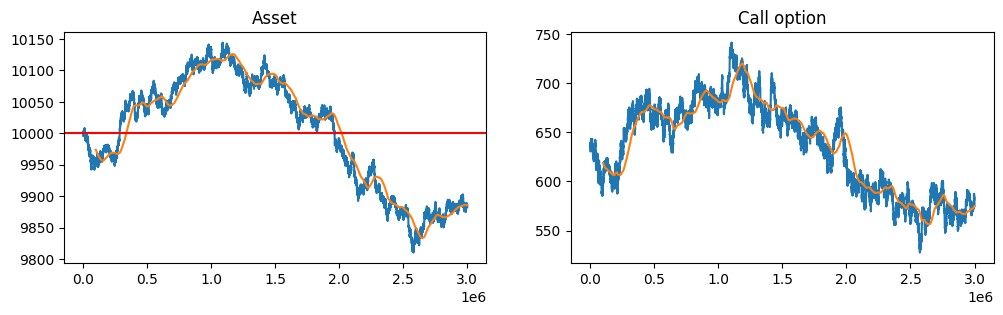

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].plot(mids['COCONUT'])
ax[0].plot(mids['COCONUT'].rolling(1000).mean())
ax[0].axhline(10000, c='r')
ax[0].set_title('Asset')
ax[1].plot(mids['COCONUT_COUPON'])
ax[1].plot(mids['COCONUT_COUPON'].rolling(1000).mean())
ax[1].set_title('Call option')
plt.show()

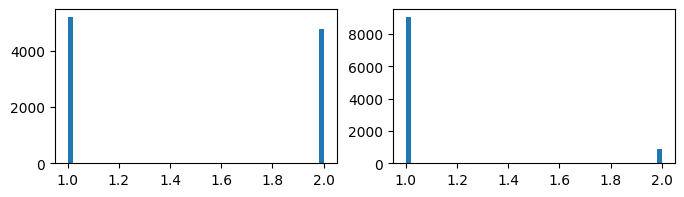

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(8, 2))
ax[0].hist(prices['COCONUT'][0]['ask_price_1'] - prices['COCONUT'][0]['bid_price_1'], bins=50)
ax[1].hist(prices['COCONUT_COUPON'][0]['ask_price_1'] - prices['COCONUT_COUPON'][0]['bid_price_1'], bins=50)
plt.show()

# Modelling Option price

In [13]:
df_asset = prices['COCONUT'][0].copy()
df_asset['group'] = df_asset.index // 10000 * 10000
df_asset = df_asset.groupby('group').mean()

df_option = prices['COCONUT_COUPON'][0].copy()
df_option['group'] = df_option.index // 10000 * 10000
df_option = df_option.groupby('group').mean()

14.392382521554934


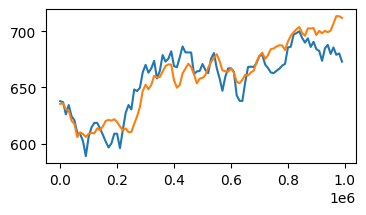

In [14]:
true_call_price = df_option['mid_price']
model_call_price = pd.Series(data=[calc_call_price(price, day=1, risk_free_rate=0.028) for price in df_asset['mid_price']], index=df_option.index)
rmse = np.sqrt(np.mean(np.square(true_call_price - model_call_price)))
print(rmse)

plt.figure(figsize=(4, 2))
plt.plot(true_call_price)
plt.plot(model_call_price)
plt.show()

In [15]:
day = 1

df_asset = prices['COCONUT'][day - 1].copy()
df_asset['group'] = df_asset.index // 10000 * 10000
df_asset = df_asset.groupby('group').mean()

df_option = prices['COCONUT_COUPON'][day - 1].copy()
df_option['group'] = df_option.index // 10000 * 10000
df_option = df_option.groupby('group').mean()

result = least_squares(calc_rmse, 0.28, args=(df_asset, df_option))
opt_r = result.x[0]
print(f'Optimal risk_free rate: {opt_r}')

rmses = []
for day in [2, 3]:
    df_asset = prices['COCONUT'][day - 1].copy()
    df_asset['group'] = df_asset.index // 10000 * 10000
    df_asset = df_asset.groupby('group').mean()
    
    df_option = prices['COCONUT_COUPON'][day - 1].copy()
    df_option['group'] = df_option.index // 10000 * 10000
    df_option = df_option.groupby('group').mean()
    
    rmses.append(calc_rmse(opt_r, df_asset, df_option))
test_rmse = np.mean(rmses)
print(f'Test set RMSE: {test_rmse}')

Optimal risk_free rate: 0.027323231503011004
Test set RMSE: 15.677914533048433


In [16]:
day = 2

df_asset = prices['COCONUT'][day - 1].copy()
df_asset['group'] = df_asset.index // 10000 * 10000
df_asset = df_asset.groupby('group').mean()

df_option = prices['COCONUT_COUPON'][day - 1].copy()
df_option['group'] = df_option.index // 10000 * 10000
df_option = df_option.groupby('group').mean()

result = least_squares(calc_rmse, 0.28, args=(df_asset, df_option))
opt_r = result.x[0]
print(f'Optimal risk_free rate: {opt_r}')

rmses = []
for day in [1, 3]:
    df_asset = prices['COCONUT'][day - 1].copy()
    df_asset['group'] = df_asset.index // 10000 * 10000
    df_asset = df_asset.groupby('group').mean()
    
    df_option = prices['COCONUT_COUPON'][day - 1].copy()
    df_option['group'] = df_option.index // 10000 * 10000
    df_option = df_option.groupby('group').mean()
    
    rmses.append(calc_rmse(opt_r, df_asset, df_option))
test_rmse = np.mean(rmses)
print(f'Test set RMSE: {test_rmse}')

Optimal risk_free rate: 0.027832665386195818
Test set RMSE: 15.204301032891504


In [17]:
day = 3

df_asset = prices['COCONUT'][day - 1].copy()
df_asset['group'] = df_asset.index // 10000 * 10000
df_asset = df_asset.groupby('group').mean()

df_option = prices['COCONUT_COUPON'][day - 1].copy()
df_option['group'] = df_option.index // 10000 * 10000
df_option = df_option.groupby('group').mean()

result = least_squares(calc_rmse, 0.28, args=(df_asset, df_option))
opt_r = result.x[0]
print(f'Optimal risk_free rate: {opt_r}')

rmses = []
for day in [1, 2]:
    df_asset = prices['COCONUT'][day - 1].copy()
    df_asset['group'] = df_asset.index // 10000 * 10000
    df_asset = df_asset.groupby('group').mean()
    
    df_option = prices['COCONUT_COUPON'][day - 1].copy()
    df_option['group'] = df_option.index // 10000 * 10000
    df_option = df_option.groupby('group').mean()
    
    rmses.append(calc_rmse(opt_r, df_asset, df_option))
test_rmse = np.mean(rmses)
print(f'Test set RMSE: {test_rmse}')

Optimal risk_free rate: 0.03112710961001096
Test set RMSE: 19.143012628468945


In [18]:
opt_r = 0.0278

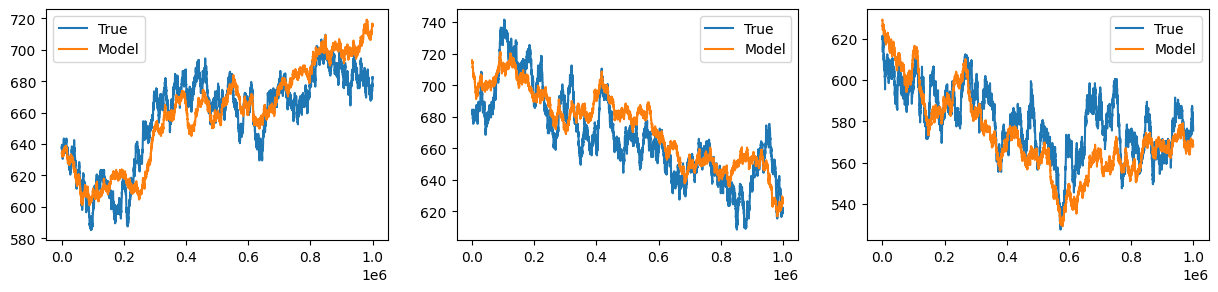

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
for i, ax in enumerate(axes.flat):
    day = i + 1
    true_call_price = prices['COCONUT_COUPON'][day - 1]['mid_price']
    model_call_price = pd.Series(
        data=[calc_call_price(curr_price, day=1, risk_free_rate=opt_r) for curr_price in prices['COCONUT'][day - 1]['mid_price']],
        index=true_call_price.index)
    ax.plot(true_call_price, label='True')
    ax.plot(model_call_price, label='Model')
    ax.legend()
plt.show()

# Delta

In [20]:
def norm_cdf(x, mu=0, sigma=1):
    z = (x - mu) / (sigma * np.sqrt(2))
    return 0.5 * (1 + math.erf(z))

In [426]:
def calc_delta(curr_price, volatility, risk_free_rate):
    strike_price = 10000
    time_to_expiration = 250 / 365
    d1 = (np.log(curr_price / strike_price) + (risk_free_rate + 0.5 * volatility**2) * time_to_expiration) / (volatility * np.sqrt(time_to_expiration))
    return norm.cdf(d1)

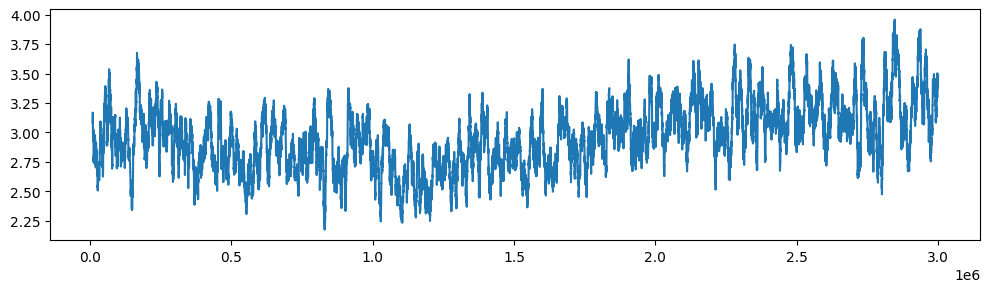

In [44]:
plt.figure(figsize=(12, 3))
plt.plot(np.log(mids['COCONUT_COUPON'] / mids['COCONUT_COUPON'].shift(1)).rolling(100).std() * np.sqrt(10000 * 252))
plt.show()

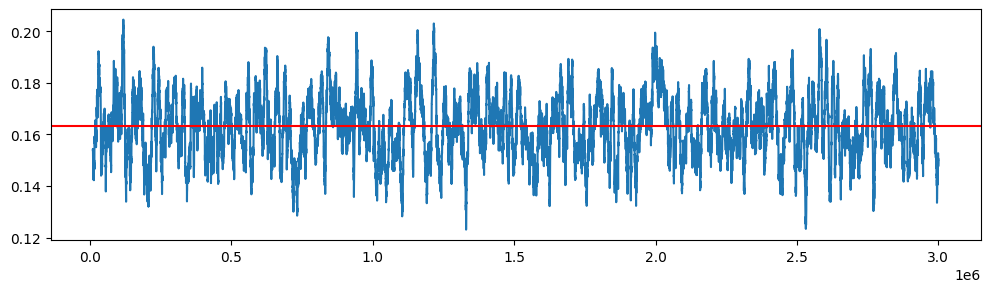

In [45]:
plt.figure(figsize=(12, 3))
plt.plot(np.log(mids['COCONUT'] / mids['COCONUT'].shift(1)).rolling(100).std() * np.sqrt(10000 * 252))
plt.axhline(0.1634, c='r')
plt.show()

In [ ]:
df = prices['COCONUT'][day - 1]
volatility = np.log(df['mid_price'] / df['mid_price'].shift(1)).std() * np.sqrt(10000 * 252)

In [443]:
day = 1
df = prices['COCONUT'][day - 1]
np.log(df['mid_price'] / df['mid_price'].shift(1)).std() * np.sqrt(10000 * 252)

0.1640549252338741

In [444]:
day = 2
df = prices['COCONUT'][day - 1]
np.log(df['mid_price'] / df['mid_price'].shift(1)).std() * np.sqrt(10000 * 252)

0.1626514783022737

In [445]:
day = 3
df = prices['COCONUT'][day - 1]
np.log(df['mid_price'] / df['mid_price'].shift(1)).std() * np.sqrt(10000 * 252)

0.16351287113126636

In [427]:
def delta_error(r):
    model_delta = pd.Series(
        data=[calc_delta(curr_price, day=1, risk_free_rate=r) for curr_price in mids['COCONUT'].iloc[:10000]], index=mids.iloc[:10000].index)
    true_delta = (mids['COCONUT_COUPON'].diff() / mids['COCONUT'].diff()).dropna().iloc[:10000].replace([np.inf, -np.inf], np.nan)
    return np.sqrt(np.mean(np.square(true_delta - model_delta)))

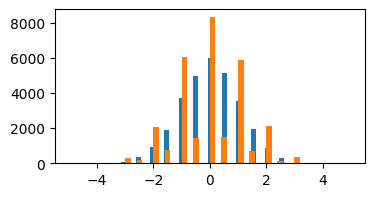

In [316]:
plt.figure(figsize=(4, 2))
plt.hist(mids['COCONUT'].diff().dropna(), bins=50)
plt.hist(mids['COCONUT_COUPON'].diff().dropna(), bins=50)
plt.show()

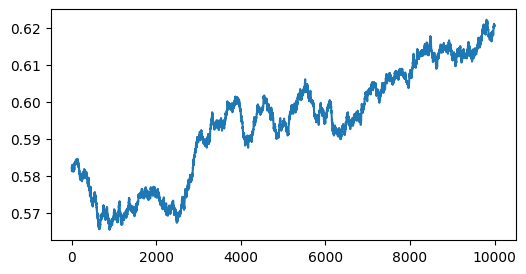

In [437]:
plt.figure(figsize=(6, 3))
plt.plot([calc_delta(curr_price, day=1, risk_free_rate=opt_r) for curr_price in mids['COCONUT'].iloc[:10000]])
plt.show()

In [434]:
delta = (mids['COCONUT_COUPON'].diff() / mids['COCONUT'].diff()).replace([np.inf, -np.inf, np.nan], 0)
delta_ma = delta.rolling(200).mean()
# delta_ma = (delta_ma + 9 * delta.mean()) / 10

In [433]:
delta.mean()

0.39432760582010584

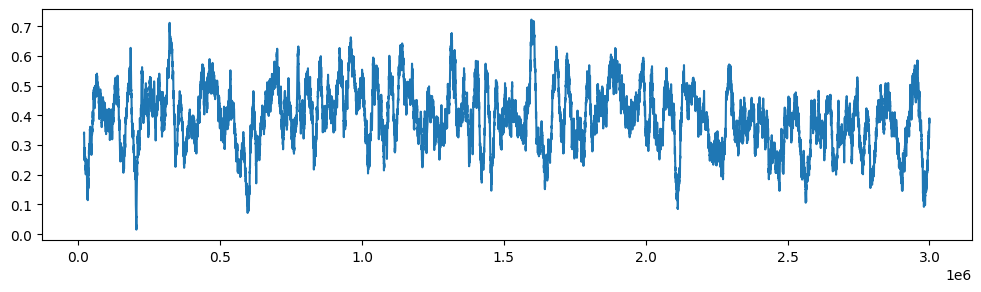

In [435]:
plt.figure(figsize=(12, 3))
plt.plot(delta_ma)
plt.show()